# Small DAE Simulations

In [1]:
from scipy.integrate import solve_ivp, solve_bvp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
import numpy as np

## Example 1

Simulate the following ODE in the domain $t\in[0,2]$:

$$ \frac{dz}{dt} = z^2 - 2z + 1 $$

with the initial condition, $z(0)=-3$. Use any collocation method. Compare the result with the analytical solution:

$$ z(t) = \frac{4t-3}{4t+1}$$

and also with SciPy's RK45 solver.

Please recompile / update your pynumero_ASL library.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       87
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       13

Total number of variables............................:       26
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables w

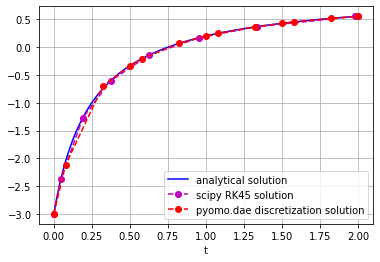

In [2]:
model = m = ConcreteModel()

m.t = ContinuousSet(bounds=(0,2))

m.z = Var(m.t)
m.dzdt = DerivativeVar(m.z)

m.obj = Objective(expr=1) # Dummy Objective

def _zdot(m, i):
    return m.dzdt[i] == m.z[i]**2 - 2*m.z[i] + 1
m.zdot = Constraint(m.t,rule=_zdot)

def _init_con(m):
    return m.z[0] == -3
m.init_con = Constraint(rule=_init_con)

# Discretize using backward finite difference
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(m, nfe=50, scheme='BACKWARD')

# Discretize using collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=4, ncp=3 , scheme='LAGRANGE-RADAU')

# Solve using Pyomo IPOPT
solver = SolverFactory('cyipopt')
solver.solve(m, tee=True)

analytical_t = [0.01*i for i in range(0,201)]
analytical_z = [(4*t-3)/(4*t+1) for t in analytical_t]

colloc_t = list(m.t)
colloc_z = [value(m.z[i]) for i in m.t]

# Solve using Scipy RK45

def dzdt(t, z):
    return z**2 - 2*z + 1

sol = solve_ivp(dzdt, [0, 2], [-3])

plt.plot(analytical_t,analytical_z, 'b',label='analytical solution')
plt.plot(sol.t, sol.y.ravel(), 'mo--',label='scipy RK45 solution')
plt.plot(colloc_t,colloc_z,'ro--',label='pyomo.dae discretization solution')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

## Example 2

Solve the following BVP within $x\in [0,10]$ using Pyomo DAE, then compare the result with Scipy BVP:

$$ y'' - y' (\sin x) + xy = \cos x $$

$$ \mathrm{B.C.}\,\, y(0)=0.5, \, y(10)=-1 $$

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      905
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      244
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      244
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

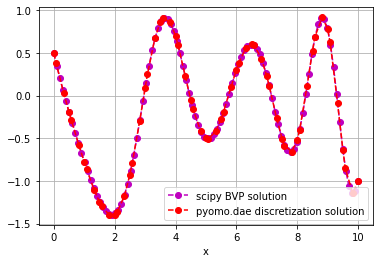

In [3]:
m = ConcreteModel()
m.xf = Param(initialize=10)
m.x = ContinuousSet(bounds=(0,m.xf))
m.y1 = Var(m.x) # This is dy/dx
m.y2 = Var(m.x) # This is the original y

m.dy1dt = DerivativeVar(m.y1) # This is dy^2/dx^2
m.dy2dt = DerivativeVar(m.y2) # This is dy/dx

m.obj = Objective(expr=1) # Dummy Objective

def _zdot1(m, i):
    return m.dy1dt[i] == m.y1[i]*np.sin(i) - i*m.y2[i] + np.cos(i)
m.zdot1 = Constraint(m.x, rule=_zdot1)

def _zdot2(m, i):
    return m.dy2dt[i] == m.y1[i]
m.zdot2 = Constraint(m.x, rule=_zdot2)

def _boundary_con(m):
    yield m.y2[0] == 0.5
    yield m.y2[m.xf] == -1
m.boundary_con = ConstraintList(rule=_boundary_con)

# Discretize using collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=20, ncp=3 , scheme='LAGRANGE-RADAU')

# Solve using Pyomo IPOPT
solver = SolverFactory('cyipopt')
solver.solve(m, tee=True)

colloc_x = list(m.x)
colloc_y = [value(m.y2[i]) for i in m.x]

# Solve using Scipy BVP
def dydt(x, y):
    return np.vstack((y[1],
                      y[1]*np.sin(x) - x*y[0] + np.cos(x)))

def bc(ya, yb):
    return ya[0]-0.5, yb[0]+1

x_bvp = np.linspace(0, 10, 100)
res = solve_bvp(dydt, bc, x_bvp, np.zeros((2, x_bvp.size)), verbose=2)
y_bvp = res.sol(x_bvp)

plt.plot(x_bvp, y_bvp[0], 'mo--', label='scipy BVP solution')
plt.plot(colloc_x,colloc_y,'ro--', label='pyomo.dae discretization solution')
plt.legend(loc='best')
plt.xlabel('x')
plt.grid()
plt.show()

## Example 3

Simulate the following SIR model for $t\in[0, 200]$ days, with $\beta=0.1$, $\gamma=0.04$, a population of $N=100$:

$$ \frac{dS}{dt}=-\frac{\beta IS}{N} $$

$$ \frac{dI}{dt}=\frac{\beta IS}{N} - \gamma I $$

$$ \frac{dR}{dt}=\gamma I $$

with initial conditions: $S(0)=95, I(0)=3$, and $R(0)=2$. Redo the simulation now with $\beta=0.08$ then compare.

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1391
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:      366
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      366
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

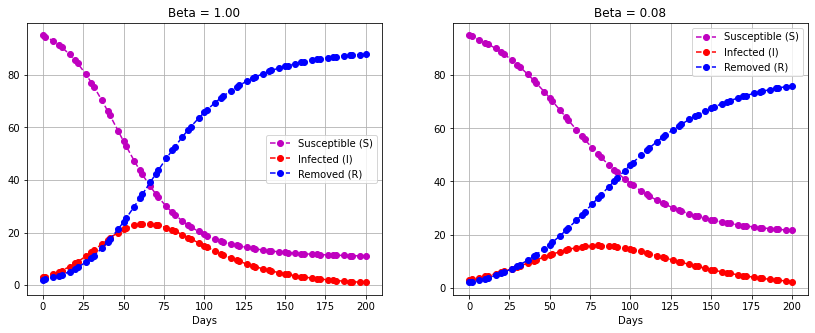

In [4]:
m = ConcreteModel()

m.t = ContinuousSet(bounds=(0,200))

m.S = Var(m.t, initialize=95)
m.I = Var(m.t, initialize=3)
m.R = Var(m.t, initialize=2)
m.beta = Param(initialize=0.1, mutable=True)
m.gamma = Param(initialize=0.04)
m.N = Param(initialize=100)
m.dSdt = DerivativeVar(m.S)
m.dIdt = DerivativeVar(m.I)
m.dRdt = DerivativeVar(m.R)

m.obj = Objective(expr=1) # Dummy Objective

m.zdot1 = Constraint(m.t, rule=lambda m, i: \
                    m.dSdt[i] == -m.beta*m.I[i]*m.S[i]/m.N)
m.zdot2 = Constraint(m.t, rule=lambda m, i: \
                    m.dIdt[i] == m.beta*m.I[i]*m.S[i]/m.N - m.gamma*m.I[i])
m.zdot3 = Constraint(m.t, rule=lambda m, i: \
                    m.dRdt[i] == m.gamma*m.I[i])

def _init_con(m):
    yield m.S[0] == 95
    yield m.I[0] == 3
    yield m.R[0] == 2
m.init_con = ConstraintList(rule=_init_con)

# Discretize using collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=20, ncp=3 , scheme='LAGRANGE-RADAU')

# Solve using Pyomo IPOPT
solver = SolverFactory('cyipopt')

plt.figure(figsize=(14,5))

solver.solve(m, tee=True)
plt.subplot(121)
plt.title('Beta = 1.00')
colloc_t = list(m.t)
colloc_S = [value(m.S[i]) for i in m.t]
colloc_I = [value(m.I[i]) for i in m.t]
colloc_R = [value(m.R[i]) for i in m.t]
plt.plot(colloc_t,colloc_S,'mo--', label='Susceptible (S)')
plt.plot(colloc_t,colloc_I,'ro--', label='Infected (I)')
plt.plot(colloc_t,colloc_R,'bo--', label='Removed (R)')
plt.legend(loc='best')
plt.xlabel('Days')
plt.grid()

# Try a different beta to reflect the effect of lockdowns and frequent hand-washing
m.beta = 0.08
solver.solve(m)
plt.subplot(122)
plt.title('Beta = 0.08')
colloc_t = list(m.t)
colloc_S = [value(m.S[i]) for i in m.t]
colloc_I = [value(m.I[i]) for i in m.t]
colloc_R = [value(m.R[i]) for i in m.t]
plt.plot(colloc_t,colloc_S,'mo--', label='Susceptible (S)')
plt.plot(colloc_t,colloc_I,'ro--', label='Infected (I)')
plt.plot(colloc_t,colloc_R,'bo--', label='Removed (R)')
plt.legend(loc='best')
plt.xlabel('Days')
plt.grid()
plt.show()